# Project 2 : Classification of Hsp70 proteins into taxonomic groups based on their amino acid sequences
 This notebook shows how we prepare the dataset, train the model and analyze the features importance. This notebook does not contain the code to compute the variation of the results (performances and feature importance), as this simply repeats what this notebook does but 30 times to obtain a statistical representation of the computed quantities. The code to be able to compute the mean and standard deviation (given in the report), is still provided in an additional notebook called `Notebook_MTP_project2_results.ipynb` . Some cells may take a lot of time to run (especially the hyperparameters optimizations) so please be aware of the estimated time indications. These time indications have been estimated using the CPU of a standard laptop.

## Table of contents
1. [Import libraries](#1.-Import-libraries)
2. [Importing and treating the dataset](#2.-Importing-and-treating-the-data-set)
3. [T-distributed stochatic neighbor embedding](#3.-TSNE)
4. [Mutual information](#4.-Mutual-information)
5. [Training of the random forest](#5.-Random-Forest)
6. [Training of the Neural Network](#6.-Neural-Network)
7. [Features importance](#7.-Features-importance)

## 1. Import libraries and install requirements
The first cell download all the required libraries. See README.md for more informations

In [5]:
%pip install -q --upgrade --user -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [17]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --user

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.1.2%2Bcu118-cp311-cp311-win_amd64.whl (2722.7 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1
    Uninstalling torch-2.2.1:
      Successfully uninstalled torch-2.2.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.


In [16]:
torch.cuda.is_available()

True

In [74]:
# Useful starting lines
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2

import pandas as pd

from python_modules.create_batch import *
from python_modules.datatreatment import *
from python_modules.neuralnet import *
from python_modules.visualisations import *
from python_modules.nn_hyperpara_opti import *
from python_modules.extract_positions import *
from python_modules.nn_hyperpara_opti_consistency import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Importing and treating the dataset
This section performs the feature embedding and selects the level of taxonomy where the model will be trained. Make sure to change the path_to_dataset variable. This section can be run in more or less 10 seconds.

In [75]:
path_to_dataset ="C:\\Users\\pierr\\OneDrive\\Bureau\\Semester_project_MA2\\dataset_hsp70_tax.csv" 
#path_to_dataset ="C:\\Users\\pierr\\Desktop\\Semester_project_Ma2\\dataset_hsp70_tax\\dataset_hsp70_tax.csv"
hsp70 = importing_data(path_to_dataset)

In [76]:
level3, level3_categ= get_data(hsp70, 2, 3,Use_Others=False)
level3=encode01(level3)
level3=category_to_int(level3,level3_categ)
columns_info = level3.drop(level3.columns[0], axis=1).columns

number of Bacteria : 
{59810}
---------
number of Eukaryota : 
{36377}
---------
number of Archaea : 
{2207}
---------
shape of dataframe : (98394, 12927)


C:\Users\pierr\OneDrive\Bureau\Semester_project_MA2\Semester_project_Ma2\python_modules\datatreatment.py:279: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [4]:
train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.8, 0.1, 0.1)

## 3. TSNE
This section performs the T-distributed stochatic neighbor embedding analysis. If done on the entire dataset, it takes 30 minutes. It can also be done on a smaller set by changing the argument of the split_dataset() function.
`X_tsne,labels_tsne,_,_,_,_=split_dataset(level3, 0.1, 0, 0)` will only execute the analysis on 10% of the dataset. Note that TSNE contains randomness, so results may vary slightly from the report and if you change the size of the subset you may need to adapt the complexity (typically a complexitiy of 150 works great with 50% of the dataset).

In [ ]:
perplexity = 350
X_tsne, labels_tsne, _, _, _, _=split_dataset(level3, 1, 0, 0)
tsne = compute_tsne(X_tsne, perplexity)
plot_tsne(tsne, labels_tsne,level3_categ)

## 4. Mutual information
This section computes the mutual information of the features in the dataset. The computation takes approximately 2 hours but can be done on a subset of the entire dataset. `mutual_data = compute_mutual_info(level3,0.1)` will perform the computation on 10 % of the dataset. We also provide a txt file `mutual_data.txt`that contains the calculated values. So, if you want to proceed without waiting for the computation (`mutual_data` is used further), just run the second cell.

In [5]:
mutual_data = compute_mutual_info(level3,0.5)
np.savetxt('mutual_data.txt', mutual_data)

Mutual info computed in 1179.6471717357635 seconds


In [5]:
mutual_data = np.loadtxt('mutual_data.txt',dtype=float)

## 5. Random Forest
This section does the training and hyperparameters optimization of the Random Forest. The hyperparameters optimization for the grid done below takes 14 hours to run. The second cell contains the optimal parameters discribed in the report, so skip the first cell if you don't want to go through the hyperparameter optimizations. The training of the Random Forest, with the hyperparameters that we selected, takes 4 minutes.

In [27]:
parameter_grid = {
        'n_estimators': [50,100],
        'max_depth':[200,300,400],
        'max_features':[100,200,400],
        'bootstrap':[False,True],
        'class_weight':['balanced'], 
        'min_samples_leaf':[5,10,20]
        }
train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.8, 0.1, 0.1)


best_para = optimize_hyperparameters_rf(train, train_label, test, test_label,parameter_grid,15)

Hyperparameters: {'n_estimators': 50, 'max_depth': 200, 'max_features': 100, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 5}, Mean Validation F1 Score: 0.9482660636318134, Std Validation F1 Score: 0.003081218817447622
Hyperparameters: {'n_estimators': 50, 'max_depth': 200, 'max_features': 100, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 10}, Mean Validation F1 Score: 0.9355854658951667, Std Validation F1 Score: 0.002970405392548438


KeyboardInterrupt: 

In [6]:
best_para = ({'n_estimators': 100, 'max_depth': 400, 'max_features': 400, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 5}, 0, 0)

Parameters are: {'n_estimators': 100, 'max_depth': 400, 'max_features': 400, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 5}
Training done
Accuracy: 97.8432%, F1 Weighted Score: 0.9783, F1 Macro score: 0.9642


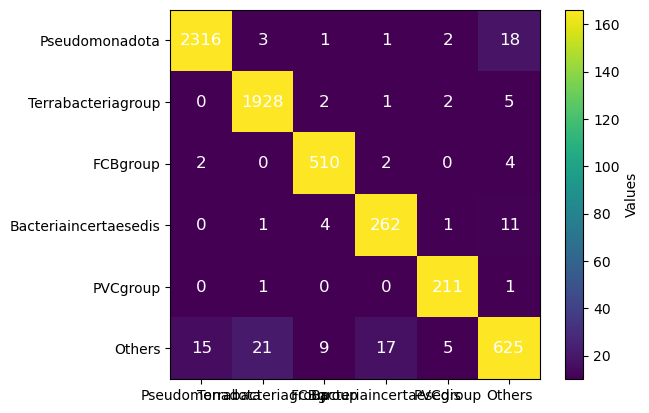

In [7]:
model_rdf = train_random_forest(train, train_label,test, test_label,best_para[0])
val_pred = model_rdf.predict(val)
convolution_matrix(val_label,val_pred,level3_categ)

## 6. Neural Network
This section does the training and hyperparameters optimization of the Neural Network. The hyperparameters optimization for the grid done below takes 14 hours to run using a GPU. The second cell contains the optimal parameters discribed in the report, so skip the first cell if you don't want to go through the hyperparameter optimization. Also, don't execute the second one if you want to use your optimized hyperparameters. The training of the Neural Network, with the hyperparameters that we selected, takes 20 seconds if a GPU is used and 4 minutes the computation is done on the CPU.

In [ ]:
param_grid = {
        'layer_dim': [64,128,256],
        'number_hidden_layer': [2,3],
        'dropout_prob': [0.2,0.3],
        'l2_regu': [1e-05],
        'weight_decay': [0.0001],
        'learning_rate':[0.001, 0.0001],
        'batch_size':[256, 128],
        'num_epochs':[10,15]
        }

positions_to_keep =range(550,600)

level3_extracted = extract_positions(level3,positions_to_keep)


train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.8, 0.1, 0.1)
cv=5
output_dim = 6
best_params_nn, mean_f1_score_nn, std_f1_score_nn = optimize_hyperparameters_nn(train, train_label, val, val_label, cv,output_dim,param_grid)

In [77]:
param_grid = {
        'layer_dim': [2],
        'number_hidden_layer': [1],
        'dropout_prob': [0.2],
        'l2_regu': [1e-05],
        'weight_decay': [0.0001],
        'learning_rate':[0.001],
        'batch_size':[10000],
        'num_epochs':[1,2]
        }

positions_to_keep =range(0,600)
nbr_training = 2

#level3_extracted = extract_positions(level3,positions_to_keep)


train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.8, 0.1, 0.1)

output_dim = 3
best_params_nn, mean_f1_score_nn, std_f1_score_nn = optimize_hyperparameters_nn_consistency(train, train_label, val, val_label, output_dim,columns_info,param_grid,nbr_training,positions_to_keep)



training
training
training
training
training
training
training
training
training
training
time: 263.86279702186584

Hyperparameters: {'layer_dim': 2, 'number_hidden_layer': 1, 'dropout_prob': 0.2, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.001, 'batch_size': 10000, 'num_epochs': 1}, Mean Validation F1 Score: 0.6004171418041493, Std Validation F1 Score: 0.11297833544478504, Mean Std of Scores: 0.35662756256673567

training
training
training
training
training
training
training
training
training
training
time: 697.310310125351

Hyperparameters: {'layer_dim': 2, 'number_hidden_layer': 1, 'dropout_prob': 0.2, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.001, 'batch_size': 10000, 'num_epochs': 2}, Mean Validation F1 Score: 0.2000629669761802, Std Validation F1 Score: 0.0, Mean Std of Scores: 0.5241573713083368


Best Hyperparameters:
{'layer_dim': 2, 'number_hidden_layer': 1, 'dropout_prob': 0.2, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.0

<Figure size 1500x1500 with 0 Axes>

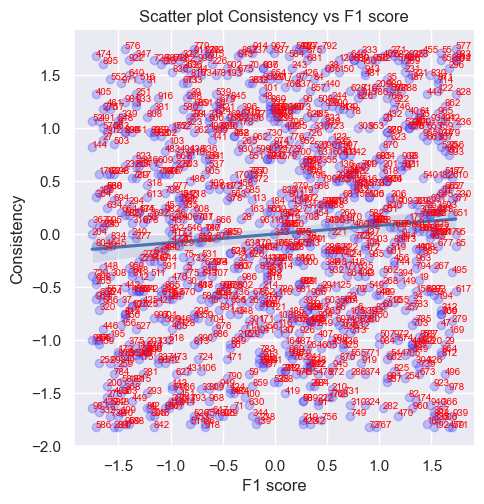

Correlation coefficient: 0.08175644911944015


In [73]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# Generate random data
x1 = [random.randint(0, 100) for _ in range(1000)]
x2 = [random.randint(0, 100) for _ in range(1000)]

# Normalize the data
data = {
    'F1 score': (np.array(x1) - np.mean(x1)) / np.std(x1),
    'Consistency': (np.array(x2) - np.mean(x2)) / np.std(x2)
}
df = pd.DataFrame(data)

plt.figure(figsize=(15, 15))

# Create scatter plot with Seaborn
sns.lmplot(
    x='F1 score', y='Consistency', data=df,
    scatter_kws={
        'alpha': 0.2,     
        'color': 'blue',    
    }
)
plt.title('Scatter plot Consistency vs F1 score')
plt.xlabel('F1 score')
plt.ylabel('Consistency')

# Annotate each point with its position in the list
for i, row in df.iterrows():
    plt.annotate(
        i, 
        (row['F1 score'], row['Consistency']),
        fontsize=7,        # Size of the labels
        alpha=1,         # Opacity of the labels
        color='red'        # Color of the labels
    )

# Show the plot
plt.show()

# Calculate and print the correlation coefficient
correlation = df['F1 score'].corr(df['Consistency'])
print(f"Correlation coefficient: {correlation}")


In [14]:
best_params_nn = {'layer_dim': 64, 'number_hidden_layer': 3, 'dropout_prob': 0.3, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.001, 'batch_size': 1024, 'num_epochs': 10}

In [19]:
#best_params_nn = {'layer_dim': 256, 'number_hidden_layer': 3, 'dropout_prob': 0.2, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.0001, 'batch_size': 256, 'num_epochs': 10}

In [32]:
layer_dim = best_params_nn['layer_dim']
number_hidden_layer = best_params_nn['number_hidden_layer']
dropout_prob = best_params_nn['dropout_prob']
l2_regu = best_params_nn['l2_regu']
weight_decay = best_params_nn['weight_decay']
learning_rate = best_params_nn['learning_rate']
batch_size = best_params_nn['batch_size']
num_epochs = best_params_nn['num_epochs']

train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.8, 0.1, 0.1)
train = torch.cat([train,val],dim = 0)
train_label = torch.cat([train_label,val_label],dim = 0)
input_dim = train.shape[1]
output_dim = 3

Epoch [1/1], Training Loss: 0.0228
Epoch [1/1], Validation Loss: 0.0273
Epoch [1/1], Validation Accuracy: 99.4918%
Accuracy: 99.4918%, F1 Weighted Score: 0.9949, F1 Macro score: 0.9728


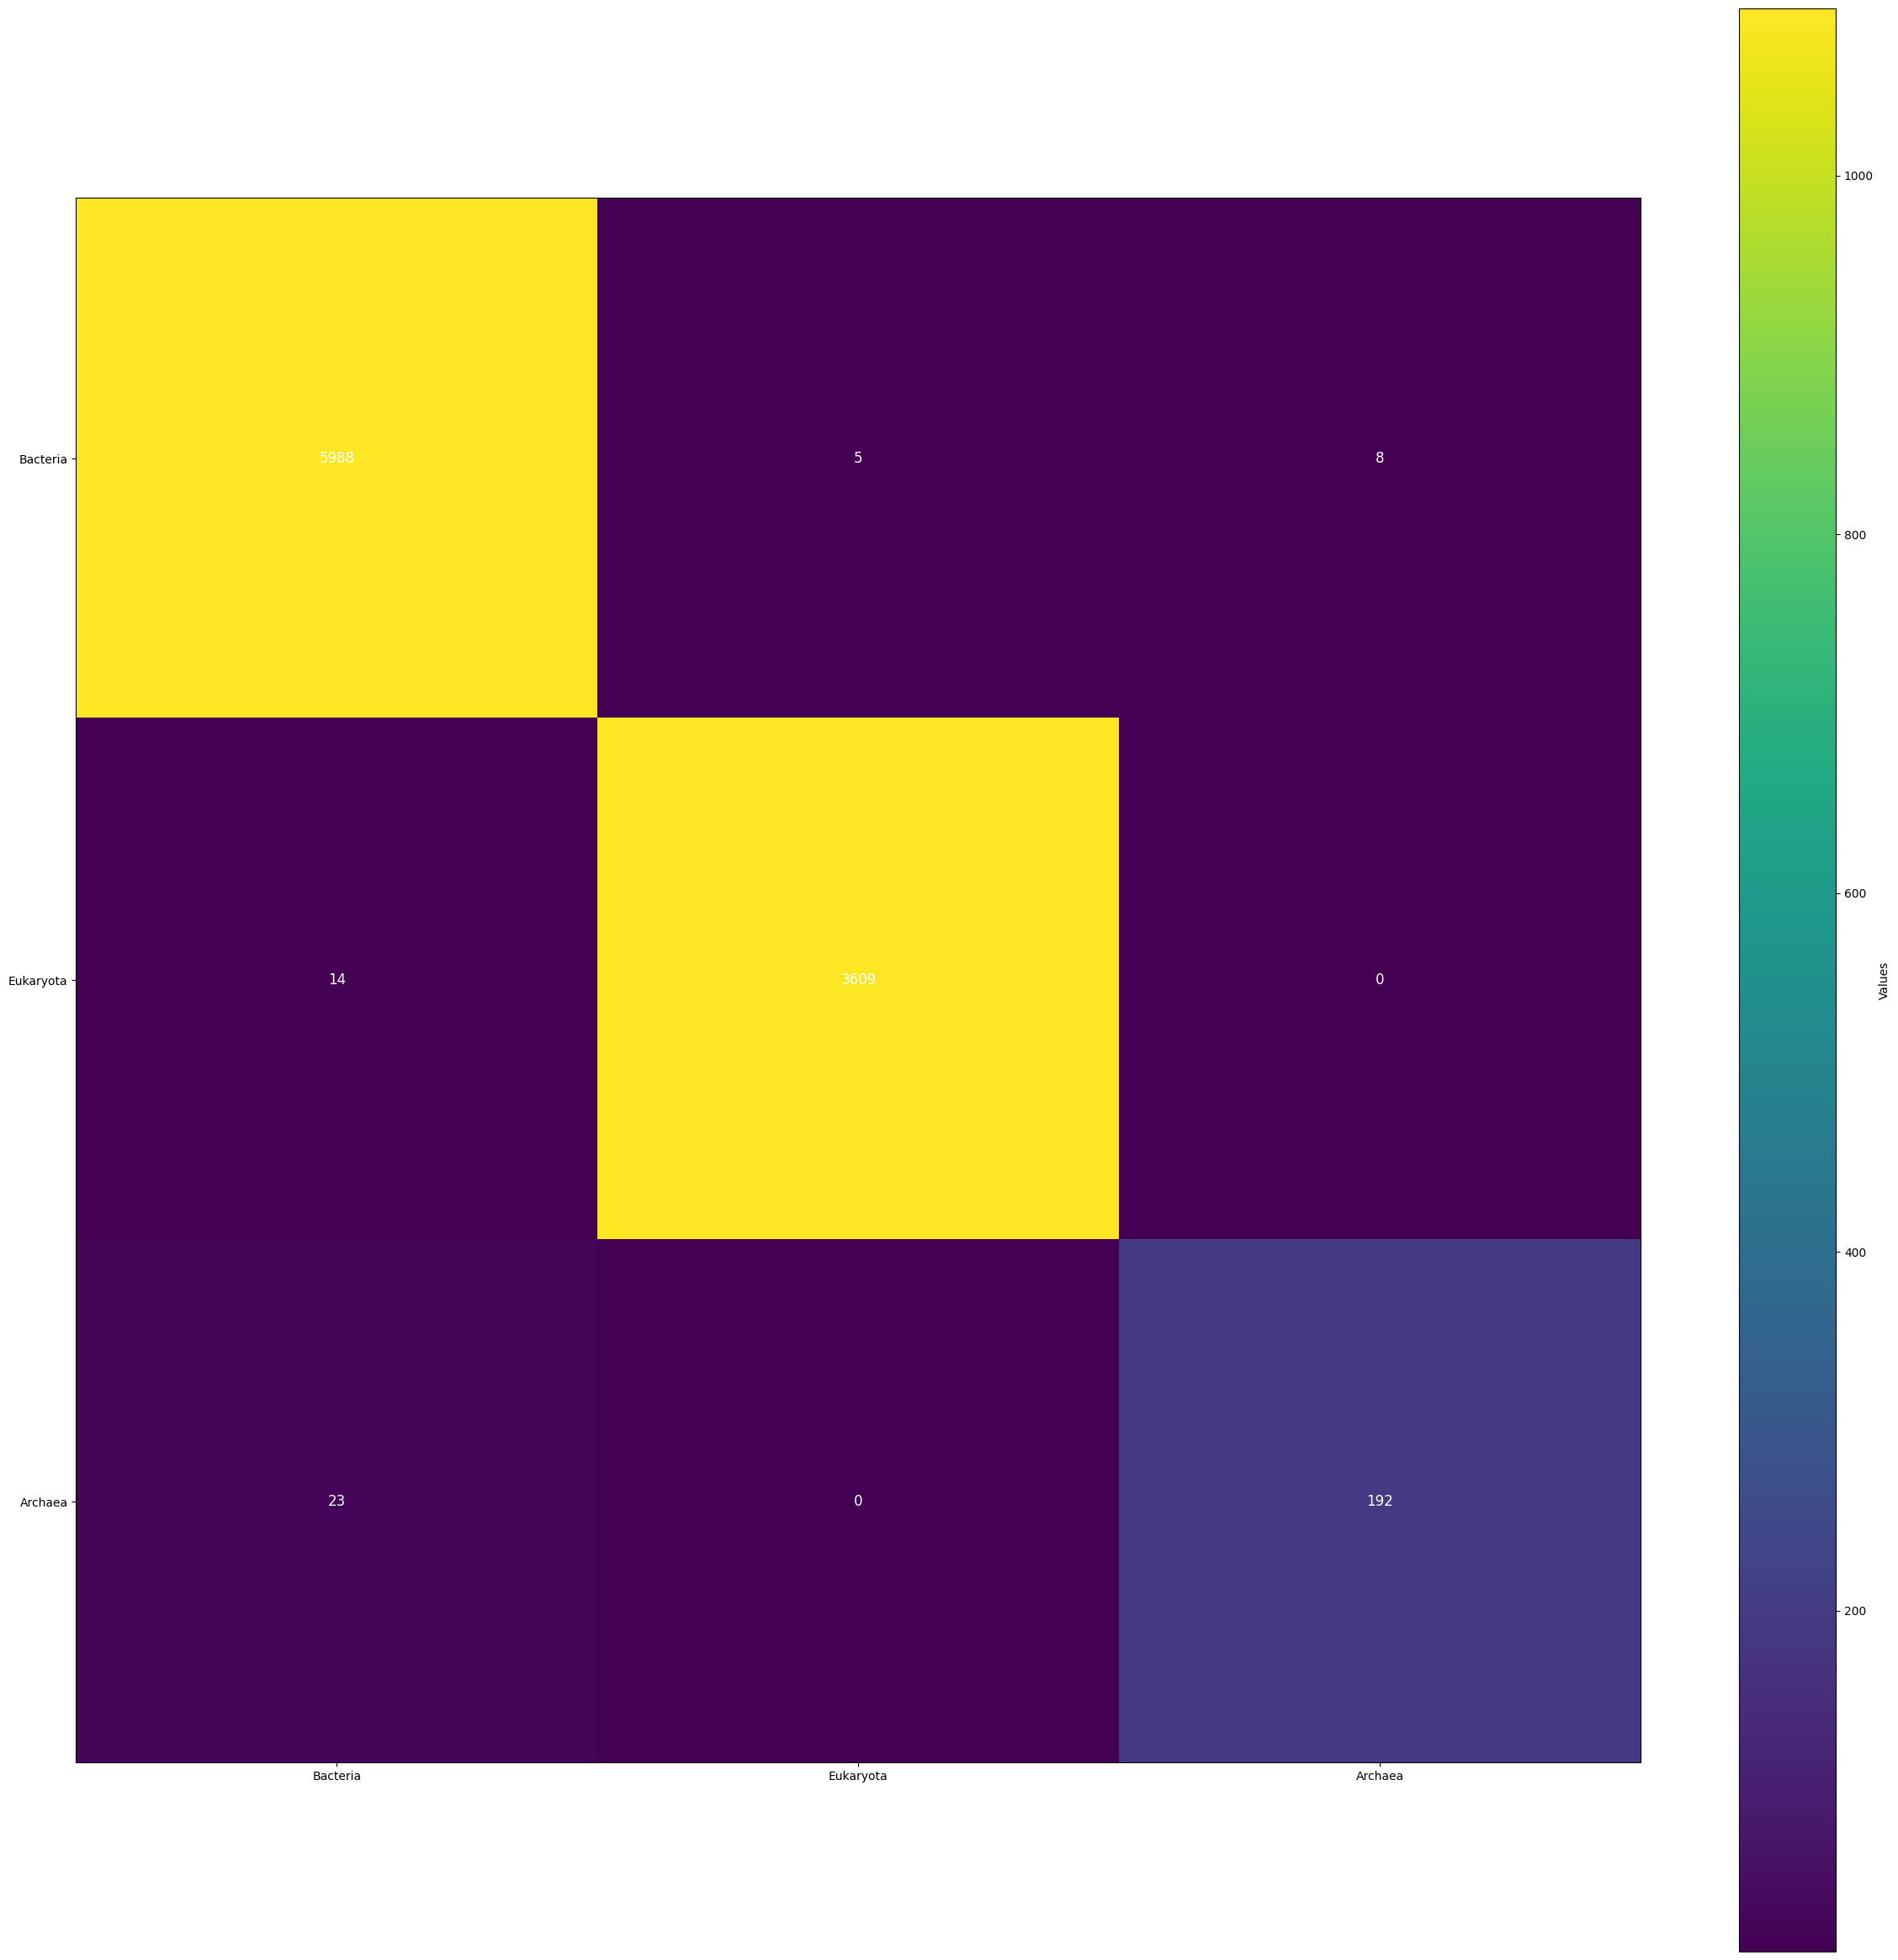

In [33]:
model_neural = ModelClassification(input_dim, output_dim, layer_dim, number_hidden_layer, dropout_prob, l2_regu)
optimizer = torch.optim.Adam(model_neural.parameters(), lr = learning_rate, weight_decay=weight_decay)
train_model(model_neural, num_epochs, train, train_label, test, test_label, optimizer, batch_size)


if torch.cuda.is_available():
    model_neural = model_neural.cpu()
test_outputs = model_neural(test)
test_pred = test_outputs.argmax(dim=1)
convolution_matrix(test_label,test_pred,level3_categ)

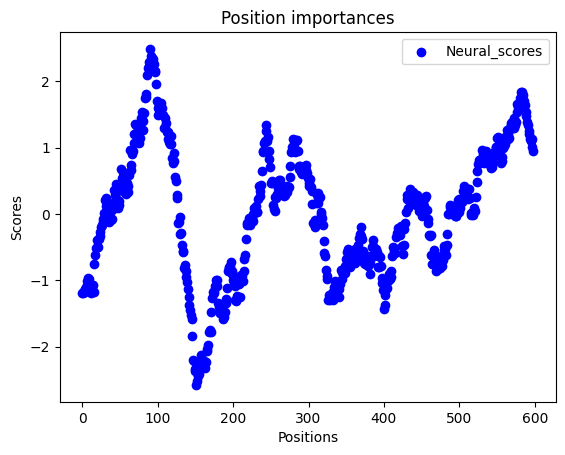

,Neural_scores
pos_0,-1.189559
pos_1,-1.192643
pos_2,-1.154298
pos_3,-1.177885
pos_4,-1.130664
...,...
pos_594,1.133951
pos_595,1.107892
pos_596,1.136499
pos_597,1.014642


In [34]:
feature_importances_neural(model_neural, columns_info, smoothness = 30, plot = 1)

Epoch [1/15], Training Loss: 1.3056
Epoch [1/15], Validation Loss: 1.2040
Epoch [1/15], Validation Accuracy: 77.7982%
Epoch [2/15], Training Loss: 0.9899
Epoch [2/15], Validation Loss: 0.9547
Epoch [2/15], Validation Accuracy: 78.7371%
Epoch [3/15], Training Loss: 0.9436
Epoch [3/15], Validation Loss: 0.8266
Epoch [3/15], Validation Accuracy: 78.7739%
Epoch [4/15], Training Loss: 0.8520
Epoch [4/15], Validation Loss: 0.7668
Epoch [4/15], Validation Accuracy: 78.9028%
Epoch [5/15], Training Loss: 0.6853
Epoch [5/15], Validation Loss: 0.7274
Epoch [5/15], Validation Accuracy: 79.0685%
Epoch [6/15], Training Loss: 0.8688
Epoch [6/15], Validation Loss: 0.6927
Epoch [6/15], Validation Accuracy: 79.1605%
Epoch [7/15], Training Loss: 0.8039
Epoch [7/15], Validation Loss: 0.6516
Epoch [7/15], Validation Accuracy: 79.1421%
Epoch [8/15], Training Loss: 0.8897
Epoch [8/15], Validation Loss: 0.6182
Epoch [8/15], Validation Accuracy: 79.1421%
Epoch [9/15], Training Loss: 0.7766
Epoch [9/15], Valida

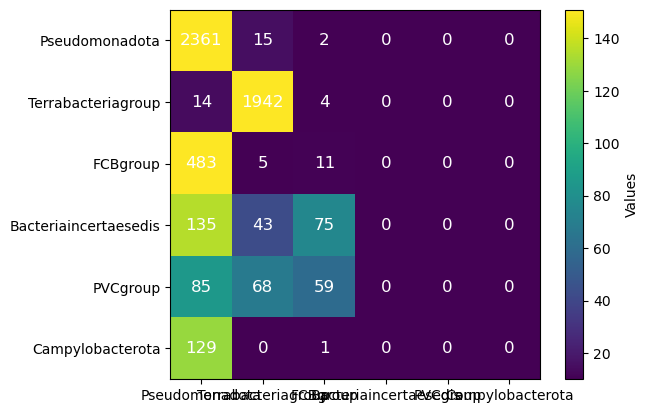

In [220]:
positions_to_keep =range(500,600)

level3_extracted = extract_positions(level3,positions_to_keep)

columns_info = level3_extracted.drop(level3_extracted.columns[0], axis=1).columns

layer_dim = best_params_nn['layer_dim']
number_hidden_layer = best_params_nn['number_hidden_layer']
dropout_prob = best_params_nn['dropout_prob']
l2_regu = best_params_nn['l2_regu']
weight_decay = best_params_nn['weight_decay']
learning_rate = best_params_nn['learning_rate']
batch_size = best_params_nn['batch_size']
num_epochs = best_params_nn['num_epochs']

train, train_label, test, test_label, val, val_label=split_dataset(level3_extracted, 0.8, 0.1, 0.1)
train = torch.cat([train,val],dim = 0)
train_label = torch.cat([train_label,val_label],dim = 0)
input_dim = train.shape[1]
output_dim = 6

model_neural = ModelClassification(input_dim, output_dim, layer_dim, number_hidden_layer, dropout_prob, l2_regu)
optimizer = torch.optim.Adam(model_neural.parameters(), lr = learning_rate, weight_decay=weight_decay)
train_model(model_neural, num_epochs, train, train_label, test, test_label, optimizer, batch_size)


if torch.cuda.is_available():
    model_neural = model_neural.cpu()
test_outputs = model_neural(test)
test_pred = test_outputs.argmax(dim=1)
convolution_matrix(test_label,test_pred,level3_categ)

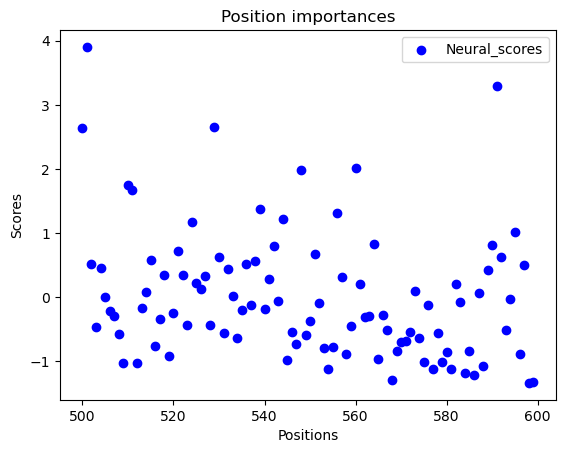

,Neural_scores
pos_500,2.638838
pos_501,3.904087
pos_502,0.519196
pos_503,-0.476639
pos_504,0.457643
...,...
pos_595,1.017287
pos_596,-0.897680
pos_597,0.494514
pos_598,-1.344236


In [221]:
feature_importances_neural(model_neural, columns_info, smoothness = 1, pos =positions_to_keep, plot = 1)

Epoch [1/10], Training Loss: 0.4871
Epoch [1/10], Validation Loss: 0.4451
Epoch [1/10], Validation Accuracy: 88.3047%
Epoch [2/10], Training Loss: 0.2409
Epoch [2/10], Validation Loss: 0.2053
Epoch [2/10], Validation Accuracy: 95.8262%
Epoch [3/10], Training Loss: 0.1752
Epoch [3/10], Validation Loss: 0.1485
Epoch [3/10], Validation Accuracy: 97.0494%
Epoch [4/10], Training Loss: 0.1487
Epoch [4/10], Validation Loss: 0.1347
Epoch [4/10], Validation Accuracy: 97.2854%
Epoch [5/10], Training Loss: 0.1097
Epoch [5/10], Validation Loss: 0.1218
Epoch [5/10], Validation Accuracy: 97.5536%
Epoch [6/10], Training Loss: 0.1592
Epoch [6/10], Validation Loss: 0.1165
Epoch [6/10], Validation Accuracy: 97.6931%
Epoch [7/10], Training Loss: 0.1134
Epoch [7/10], Validation Loss: 0.1178
Epoch [7/10], Validation Accuracy: 97.5966%
Epoch [8/10], Training Loss: 0.0912
Epoch [8/10], Validation Loss: 0.1173
Epoch [8/10], Validation Accuracy: 97.6609%
Epoch [9/10], Training Loss: 0.0971
Epoch [9/10], Valida

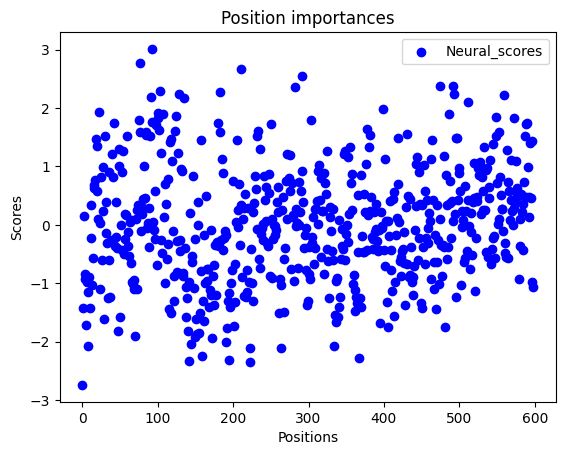

Got to iteration 1 in 329.6698431968689 seconds
Epoch [1/10], Training Loss: 0.5150
Epoch [1/10], Validation Loss: 0.4194
Epoch [1/10], Validation Accuracy: 89.7103%
Epoch [2/10], Training Loss: 0.2379
Epoch [2/10], Validation Loss: 0.1905
Epoch [2/10], Validation Accuracy: 95.7082%
Epoch [3/10], Training Loss: 0.1938
Epoch [3/10], Validation Loss: 0.1373
Epoch [3/10], Validation Accuracy: 97.2747%
Epoch [4/10], Training Loss: 0.1282
Epoch [4/10], Validation Loss: 0.1218
Epoch [4/10], Validation Accuracy: 97.5966%
Epoch [5/10], Training Loss: 0.1406
Epoch [5/10], Validation Loss: 0.1138
Epoch [5/10], Validation Accuracy: 97.5751%
Epoch [6/10], Training Loss: 0.0968
Epoch [6/10], Validation Loss: 0.1083
Epoch [6/10], Validation Accuracy: 97.8219%
Epoch [7/10], Training Loss: 0.1280
Epoch [7/10], Validation Loss: 0.1059
Epoch [7/10], Validation Accuracy: 97.9506%
Epoch [8/10], Training Loss: 0.0845
Epoch [8/10], Validation Loss: 0.1035
Epoch [8/10], Validation Accuracy: 97.8863%
Epoch [9

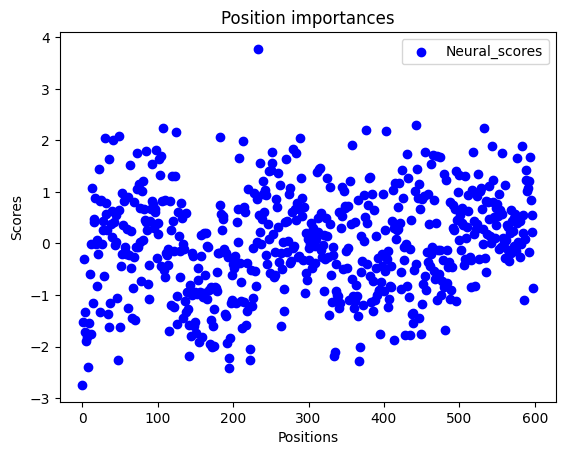

Got to iteration 2 in 873.9781157970428 seconds
Epoch [1/10], Training Loss: 0.5463
Epoch [1/10], Validation Loss: 0.4251
Epoch [1/10], Validation Accuracy: 89.9356%
Epoch [2/10], Training Loss: 0.2838
Epoch [2/10], Validation Loss: 0.2004
Epoch [2/10], Validation Accuracy: 96.1481%
Epoch [3/10], Training Loss: 0.1667
Epoch [3/10], Validation Loss: 0.1577
Epoch [3/10], Validation Accuracy: 97.1137%
Epoch [4/10], Training Loss: 0.1375
Epoch [4/10], Validation Loss: 0.1376
Epoch [4/10], Validation Accuracy: 97.4249%
Epoch [5/10], Training Loss: 0.1281
Epoch [5/10], Validation Loss: 0.1302
Epoch [5/10], Validation Accuracy: 97.6609%
Epoch [6/10], Training Loss: 0.1300
Epoch [6/10], Validation Loss: 0.1243
Epoch [6/10], Validation Accuracy: 97.6931%
Epoch [7/10], Training Loss: 0.1081
Epoch [7/10], Validation Loss: 0.1233
Epoch [7/10], Validation Accuracy: 97.7146%
Epoch [8/10], Training Loss: 0.1334
Epoch [8/10], Validation Loss: 0.1234
Epoch [8/10], Validation Accuracy: 97.8326%
Epoch [9

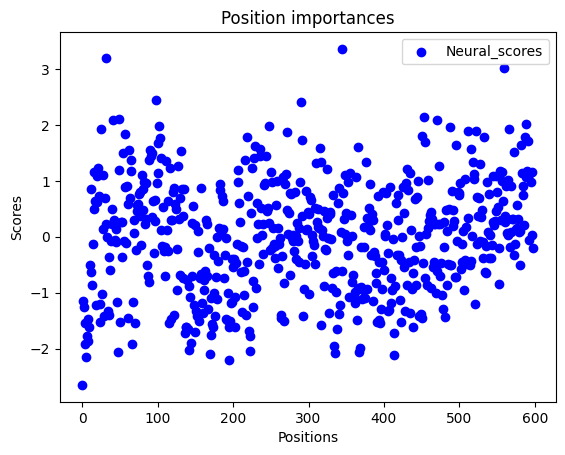

Got to iteration 3 in 1346.0821573734283 seconds


In [21]:
best_params_nn = {'layer_dim': 64, 'number_hidden_layer': 3, 'dropout_prob': 0.3, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.001, 'batch_size': 1024, 'num_epochs': 10}
number_hidden_layer = best_params_nn['number_hidden_layer']
dropout_prob = best_params_nn['dropout_prob']
l2_regu = best_params_nn['l2_regu']
weight_decay = best_params_nn['weight_decay']
learning_rate = best_params_nn['learning_rate']
batch_size = best_params_nn['batch_size']
num_epochs = best_params_nn['num_epochs']

positions_to_keep =range(0,599)

#level3_extracted = extract_positions(level3,positions_to_keep)
level3_extracted = level3

output_dim = 30
tic = time.time()

dfs = []
for i in range(3):
    
    train, train_label, test, test_label, val, val_label=split_dataset(level3_extracted, 0.8, 0.1, 0.1)
    input_dim = train.shape[1]
    
    model_neural = ModelClassification(input_dim, output_dim, layer_dim, number_hidden_layer, dropout_prob, l2_regu)
    optimizer = torch.optim.Adam(model_neural.parameters(), lr = learning_rate, weight_decay=weight_decay)#lr : learning rate
    train_model(model_neural, num_epochs, train, train_label, test, test_label, optimizer, batch_size)
    
    dfs.append(feature_importances_neural(model_neural, level3_extracted.drop(level3_extracted.columns[0], axis=1).columns, smoothness = 0, pos =positions_to_keep, plot = 1))
    t = time.time() - tic
    print(f"Got to iteration {i+1} in {t} seconds")
    
    

arrays = [df.to_numpy() for df in dfs]

stacked_array = np.stack(arrays, axis=0)
mean_values = np.mean(stacked_array, axis=0)
std_values = np.std(stacked_array, axis=0)


np.savetxt('mean_total.txt', mean_values)
np.savetxt('std_total.txt', std_values)

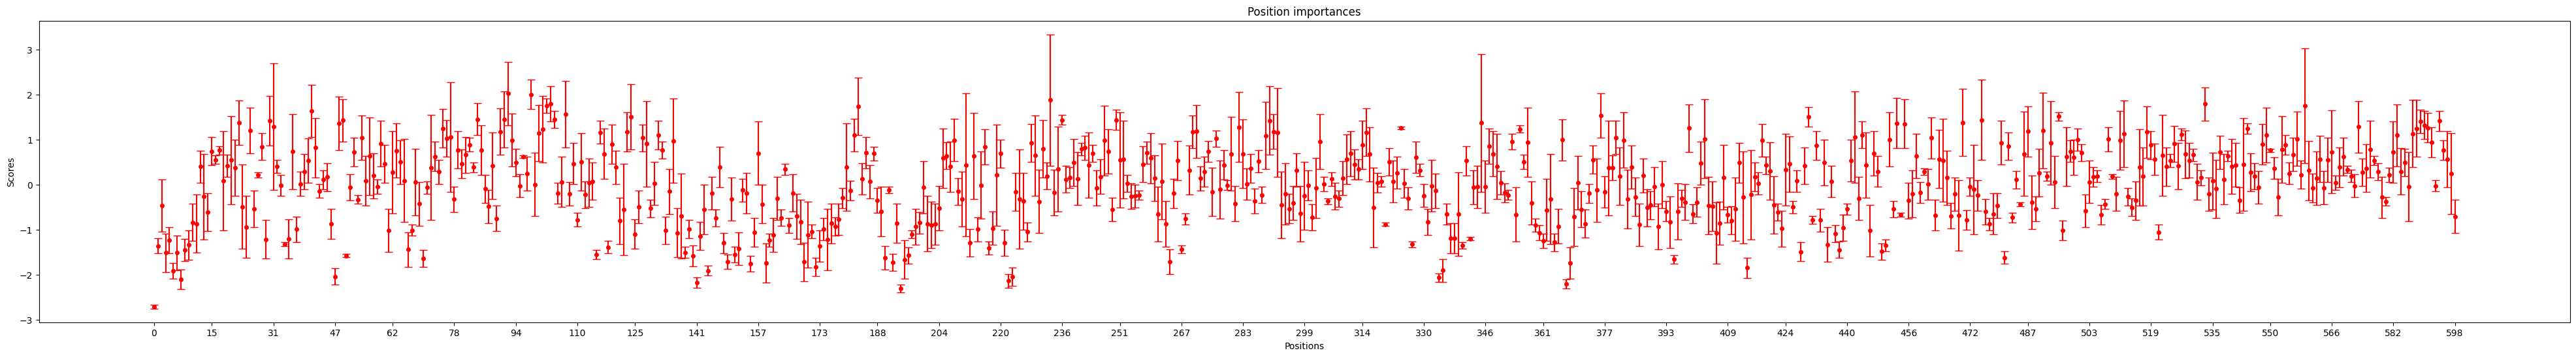

In [22]:
plt.figure(figsize=(50, 6))


plt.errorbar(positions_to_keep, mean_values[:, 0], std_values[:, 0], capsize=4, color="red", fmt="o", markersize=4)

plt.xlabel('Positions')
plt.ylabel('Scores')
plt.title('Position importances')


num_ticks = len(positions_to_keep)//15
xticks_indices = np.linspace(0, len(positions_to_keep) - 1, num_ticks, dtype=int)
plt.xticks(np.array(positions_to_keep)[xticks_indices])

plt.savefig('Postitionimportances_task30.png', dpi=200)
plt.show()


## 7. Features importance
This section computes the features importance in both model and standardizes them. They are then plotted in comparison with the mutual informations to be able to see which region of the sequence is more important for the task. Note that the signal is filtered through a moving average of size `smoothness`. The first cell contains the feature importance calculated by all models and the second is just the feature importance in the neural network However, the importance is divided between each class to observe whether they match. We provide 2 .pkl files to be able to visualize the importances without the need to run the entire notebook. If you want to compute the features importance of the models trained, do not run the first cell.

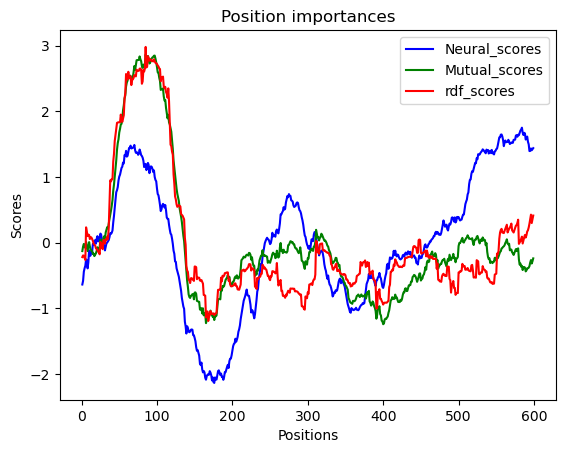

,Neural_scores,Mutual_scores,rdf_scores
pos_1,-0.635912,-0.126754,-0.217961
pos_2,-0.580478,-0.057838,-0.192978
pos_3,-0.441222,-0.018056,-0.196879
pos_4,-0.388720,-0.053526,-0.230814
pos_5,-0.349460,-0.079059,-0.262495
...,...,...,...
pos_595,1.397936,-0.300676,0.359578
pos_596,1.435891,-0.263739,0.427610
pos_597,1.408192,-0.316336,0.300138
pos_598,1.425696,-0.282011,0.359709


In [18]:
feature_importances(model_rdf, model_neural, mutual_data, level3, smoothness = 80, plot = 1)

In [ ]:
features_impo = pd.read_pickle('features_impo.pkl')
features_impo_nn = pd.read_pickle('features_impo_nn.pkl')

In [ ]:
features_impo = feature_importances(model_rdf, model_neural, mutual_data, level3, smoothness = 30)
features_impo.to_pickle("features_impo.pkl")

In [ ]:
features_impo_nn = features_importances_nn(model_neural, level3, smoothness = 30, plot=1)
features_impo_nn.to_pickle("features_impo_nn.pkl")

## Plot finaux

In [10]:
best_params_nn = {'layer_dim': 128, 'number_hidden_layer': 3, 'dropout_prob': 0.2, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.0001, 'batch_size': 256, 'num_epochs': 10}
layer_dim = best_params_nn['layer_dim']
number_hidden_layer = best_params_nn['number_hidden_layer']
dropout_prob = best_params_nn['dropout_prob']
l2_regu = best_params_nn['l2_regu']
weight_decay = best_params_nn['weight_decay']
learning_rate = best_params_nn['learning_rate']
batch_size = best_params_nn['batch_size']
num_epochs = best_params_nn['num_epochs']


best_para = ({'n_estimators': 100, 'max_depth': 400, 'max_features': 400, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 5}, 0, 0)

dfs = []
for i in range(30):
    
    
    train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.9, 0.1, 0)
    
    model_rdf = train_random_forest(train, train_label,test, test_label,best_para[0])
    model_neural = ModelClassification(input_dim, output_dim, layer_dim, number_hidden_layer, dropout_prob, l2_regu)
    optimizer = torch.optim.Adam(model_neural.parameters(), lr = learning_rate, weight_decay=weight_decay)#lr : learning rate
    train_model(model_neural, num_epochs, train, train_label, test, test_label, optimizer, batch_size)
    
    dfs.append(feature_importances(model_rdf, model_neural, mutual_data, level3, smoothness = 40, plot = 0))

    mutual_data = compute_mutual_info(level3,1)
    
    
    

arrays = [df.to_numpy() for df in dfs]

stacked_array = np.stack(arrays, axis=0)
mean_values = np.mean(stacked_array, axis=0)
std_values = np.std(stacked_array, axis=0)


np.savetxt('mean.txt', mean_values)
np.savetxt('std.txt', std_values)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\pierr\anaconda3\envs\Cuda\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\pierr\AppData\Local\Temp\ipykernel_66192\1665171161.py", line 18, in <module>
    train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.9, 0.1, 0)
                                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pierr\Desktop\Semester_project_Ma2\create_batch.py", line 63, in split_dataset
    train_set = torch.tensor(trainset.iloc[:, 1:].values, dtype=torch.float32)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

During handling of the above exception, another exception occurred:

Traceb

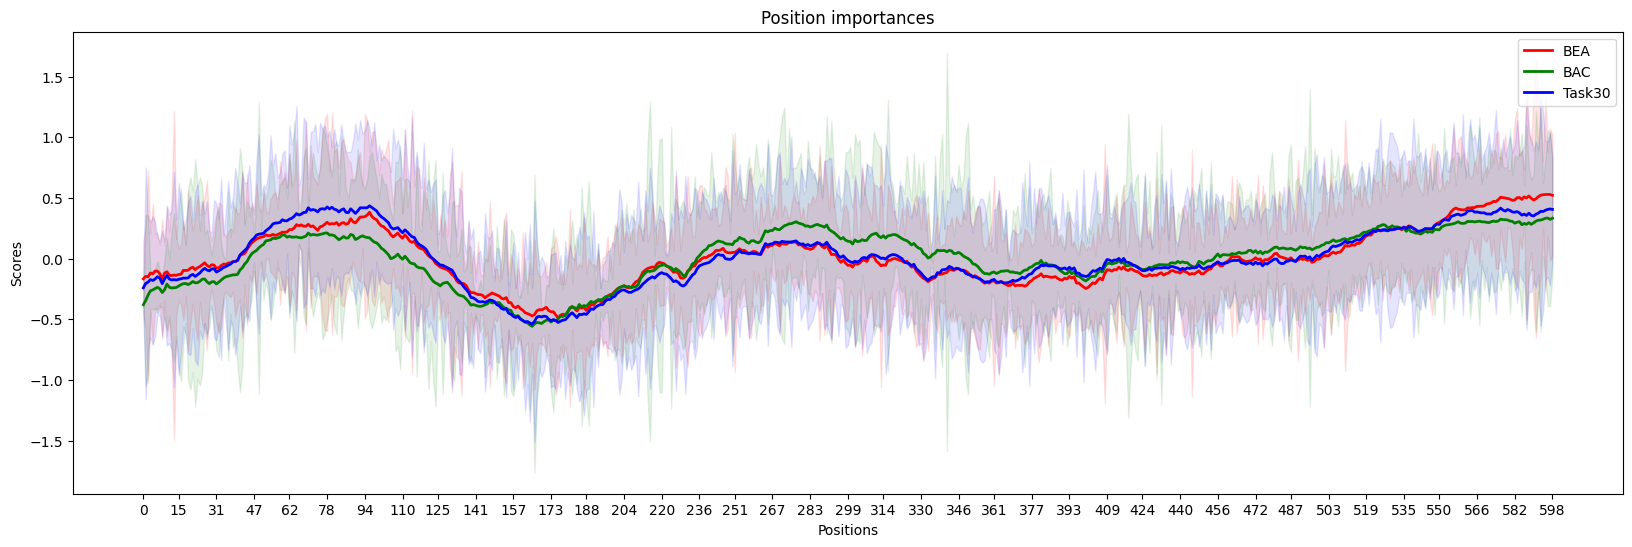

In [98]:
# Load data into pandas DataFrames
df_BEA = pd.read_csv('mean_BEA.txt', header=None, names=['mean'])
df_BEA['std'] = pd.read_csv('std_BEA.txt', header=None, names=['std'])

df_BAC = pd.read_csv('mean_BAC.txt', header=None, names=['mean'])
df_BAC['std'] = pd.read_csv('std_BAC.txt', header=None, names=['std'])

df_task30 = pd.read_csv('mean_task30.txt', header=None, names=['mean'])
df_task30['std'] = pd.read_csv('std_task30.txt', header=None, names=['std'])

# Apply rolling average
smoothness = 80
df_BEA['mean'] = df_BEA['mean'].rolling(window=smoothness, min_periods=1, center=True).mean()
df_BAC['mean'] = df_BAC['mean'].rolling(window=smoothness, min_periods=1, center=True).mean()
df_task30['mean'] = df_task30['mean'].rolling(window=smoothness, min_periods=1, center=True).mean()



plt.figure(figsize=(20, 6))

plt.plot(np.arange(df_BEA['mean'].shape[0]), df_BEA['mean'],label='BEA', color="red", lw=2) 


plt.fill_between(
    np.arange(df_BEA['mean'].shape[0]),
    df_BEA['mean'] - df_BEA['std'],
    df_BEA['mean'] + df_BEA['std'],
    color="red",
    alpha=0.1 
)
plt.plot(np.arange(df_BAC['mean'].shape[0]), df_BAC['mean'], label='BAC', color="green", lw=2) 
plt.fill_between(
    np.arange(df_BAC['mean'].shape[0]),
    df_BAC['mean'] - df_BAC['std'],
    df_BAC['mean'] + df_BAC['std'],
    color="green",
    alpha=0.1 
)
plt.plot(np.arange(df_task30['mean'].shape[0]), df_task30['mean'], label='Task30', color="blue", lw=2) 
plt.fill_between(
    np.arange(df_task30['mean'].shape[0]),
    df_task30['mean'] - df_task30['std'],
    df_task30['mean'] + df_task30['std'],
    color="blue",
    alpha=0.1 
)


num_ticks = len(df_BEA['mean'])//15
xticks_indices = np.linspace(0, len(df_BEA['mean']) - 1, num_ticks, dtype=int)

plt.xticks(np.arange(df_BEA['mean'].shape[0])[xticks_indices])



plt.xlabel('Positions')
plt.ylabel('Scores')
plt.title('Position importances')
plt.legend()
plt.savefig('Positionimportances_all.png', dpi=200)

plt.show()




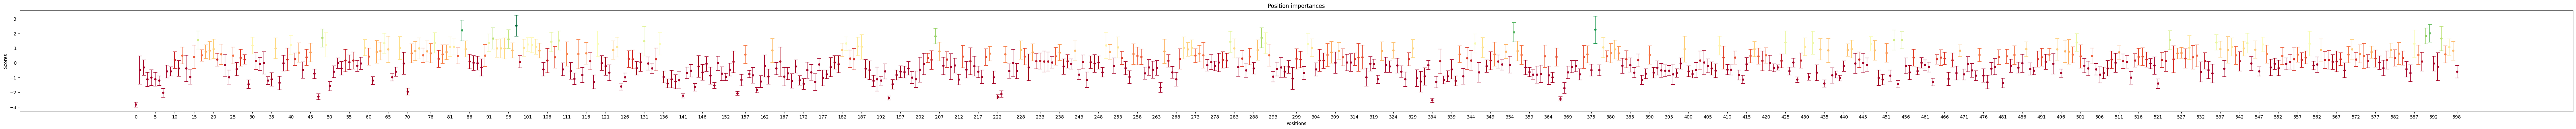

In [52]:

# Load data into pandas DataFrames
df = pd.read_csv('mean_task30.txt', header=None, names=['mean'])
df['std'] = pd.read_csv('std_task30.txt', header=None, names=['std'])

# Plot the data
plt.figure(figsize=(100, 4))


plt.xlabel('Positions')
plt.ylabel('Scores')
plt.title('Position importances')


colors = plt.cm.RdYlGn(df['mean'] / df['mean'].max())

for i in range(len(df["mean"])):
    plt.errorbar(i, df["mean"][i], df["std"][i], capsize=4, color=colors[i], fmt="o", markersize=4)


# Set x ticks
num_ticks = len(df["mean"]) // 5
xticks_indices = np.linspace(0, len(df["mean"]) - 1, num_ticks, dtype=int)
plt.xticks(np.arange(len(df["mean"]))[xticks_indices])

plt.savefig('Positionimportances_opti_task30.png', dpi=200)
plt.show()

## Modify the PDB file

In [8]:
df = pd.read_csv('mean_BAC.txt', header=None, names=['mean'])
smoothness = 80
df['mean'] = df['mean'].rolling(window=smoothness, min_periods=1, center=True).mean()

scores = df['mean']
input_file = "5nro.pdb"

Modify_PDB_file(input_file, scores)


5nro_scores.pdb has been created with 5097 values modified


# Figure Generation

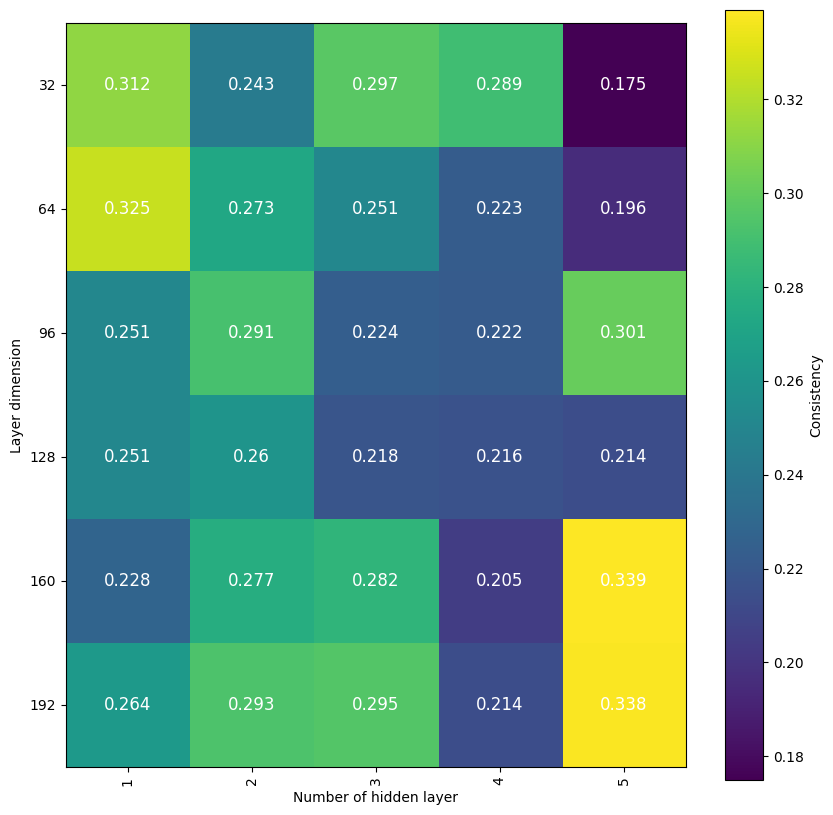

In [15]:
# Example usage
matrix = [
    [0.312, 0.243,0.297, 0.289,0.175],
    [0.325, 0.273,0.251, 0.223,0.196],
    [0.251, 0.291,0.224, 0.222,0.301],
    [0.251, 0.260,0.218, 0.216,0.214],
    [0.228, 0.277,0.282, 0.205,0.339],
    [0.264, 0.293,0.295, 0.214,0.338]
]

y_ticks = ['32', '64', '96','128','160','192']
x_ticks = ['1', '2', '3','4','5']
y_label = 'Layer dimension'
x_label = 'Number of hidden layer'


plt.figure(figsize=(10, 10))


plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=np.min(matrix), vmax=np.max(matrix))


for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        plt.text(j, i, str(matrix[i][j]), ha='center', va='center', color='white', fontsize=12)


plt.xticks(range(len(x_ticks)), x_ticks, rotation=90)
plt.yticks(range(len(y_ticks)), y_ticks)

# Label the axes
plt.xlabel(x_label)
plt.ylabel(y_label)

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Consistency')

# Display the plot
plt.show()


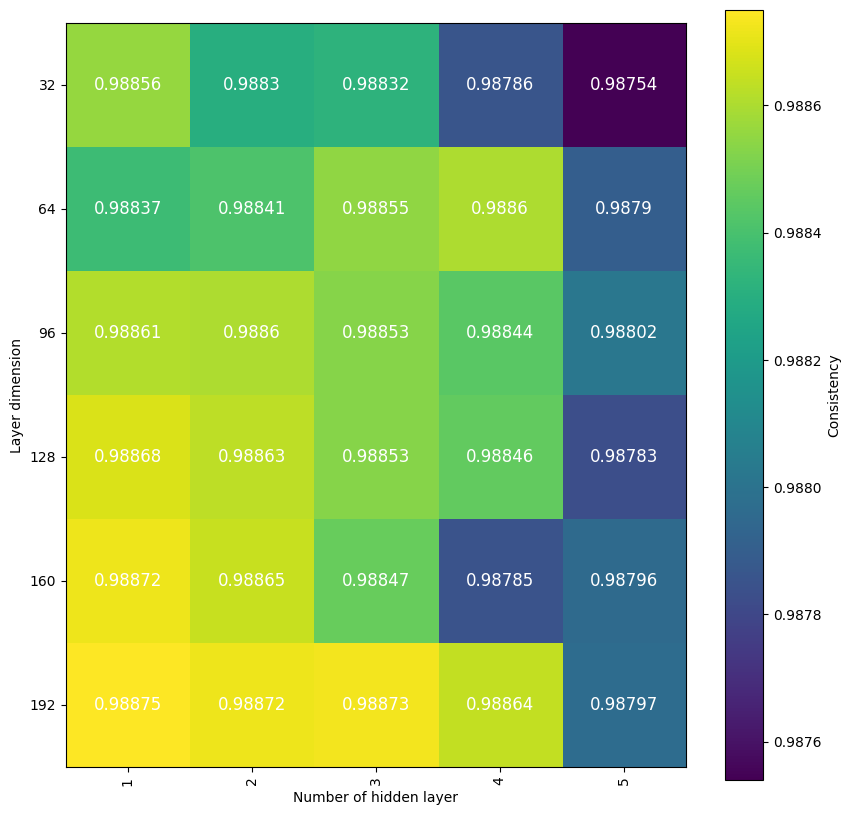

In [16]:
# Example usage
matrix = [
    [ 0.98856, 0.98830,0.98832, 0.98786,0.98754],
    [0.98837,0.98841,0.98855, 0.98860,0.98790],
    [0.98861, 0.98860,0.98853, 0.98844,0.98802],
    [0.98868, 0.98863,0.98853, 0.98846,0.98783],
    [0.98872, 0.98865,0.98847, 0.98785,0.98796],
    [0.98875, 0.98872,0.98873, 0.98864,0.98797]
]

y_ticks = ['32', '64', '96','128','160','192']
x_ticks = ['1', '2', '3','4','5']
y_label = 'Layer dimension'
x_label = 'Number of hidden layer'


plt.figure(figsize=(10, 10))


plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=np.min(matrix), vmax=np.max(matrix))


for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        plt.text(j, i, str(matrix[i][j]), ha='center', va='center', color='white', fontsize=12)


plt.xticks(range(len(x_ticks)), x_ticks, rotation=90)
plt.yticks(range(len(y_ticks)), y_ticks)

# Label the axes
plt.xlabel(x_label)
plt.ylabel(y_label)

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Consistency')

# Display the plot
plt.show()
